In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Selecting qubits and calibrating circuits for an experiment

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/advanced_calibration"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/google/advanced_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/google/advanced_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/advanced_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to select good qubits and calibrate circuits for an experiment. The high-level steps are:

1. Using the latest calibration data, identify and select a good set of qubits.
2. Run a Loschmidt echo benchmark on these qubits to verify calibration data.
3. Calibrate qubit pairs in your circuit using Floquet calibration and/or XEB calibration.
4. Re-run the Loschmidt echo benchmark with calibration.
5. Apply corrections to your circuit from the calibration which performs best on the Loschmidt echo.

These steps are recommended as a minimum procedure for running on the [Quantum Computing Service (QCS)](https://quantumai.google/cirq/google/concepts). Additional steps to mitigating errors, perhaps specific to your experiment, can be added on top of this workflow.

Disclaimer: The data shown in this tutorial is exemplary and not representative of the QCS in production.

## Setup

In [3]:
try:
    import cirq
except ImportError:
    !pip install cirq --quiet

In [4]:
# The Google Cloud Project id to use.
project_id = '' #@param {type:"string"}

if project_id == '':
    import os 
    if 'GOOGLE_CLOUD_PROJECT' not in os.environ:
        raise Exception("Please setup project_id in this cell or set the `GOOGLE_CLOUD_PROJECT` env var to your project id.")
    project_id = os.environ['GOOGLE_CLOUD_PROJECT']
else: 
    import os
    os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

def authenticate_user():
    """Runs the user through the Colab OAuth process.

    Checks for Google Application Default Credentials and runs interactive login 
    if the notebook is executed in Colab. In case the notebook is executed in Jupyter notebook
    or other IPython runtimes, no interactive login is provided, it is assumed that the 
    `GOOGLE_APPLICATION_CREDENTIALS` env var is set or `gcloud auth application-default login`
    was executed already.

    For more information on using Application Default Credentials see 
    https://cloud.google.com/docs/authentication/production
    """
    in_colab = False
    try:
        from IPython import get_ipython
        in_colab = 'google.colab' in str(get_ipython())
    except: 
        # Notebook is not executed within IPython. Assuming external authentication.
        return 

    if in_colab: 
        from google.colab import auth      
        print("Getting OAuth2 credentials.")
        print("Press enter after entering the verification code.")
        auth.authenticate_user(clear_output=False)
        print("Authentication complete.")
    else: 
        print("Notebook is not executed with Colab, assuming Application Default Credentials are setup.") 

authenticate_user()

print("Successful authentication to Google Cloud.")

Getting OAuth2 credentials.
Press enter after entering the verification code.
Authentication complete.
Successful authentication to Google Cloud.


In [5]:
import cirq
from cirq.experiments import random_quantum_circuit_generation as rqcg
import cirq_google as cg

import matplotlib.pyplot as plt
import numpy as np

## Select qubits

Below, select a processor and (comma-separated list of) calibration metric(s) to visualize the latest calibration report.

Note: All calibration metrics are defined in [this guide](https://quantumai.google/cirq/google/calibration). If you are unsure which metric to focus on for your experiment, we recommend `parallel_p00_error` and `parallel_p11_error` to eliminate qubits with high readout errors.

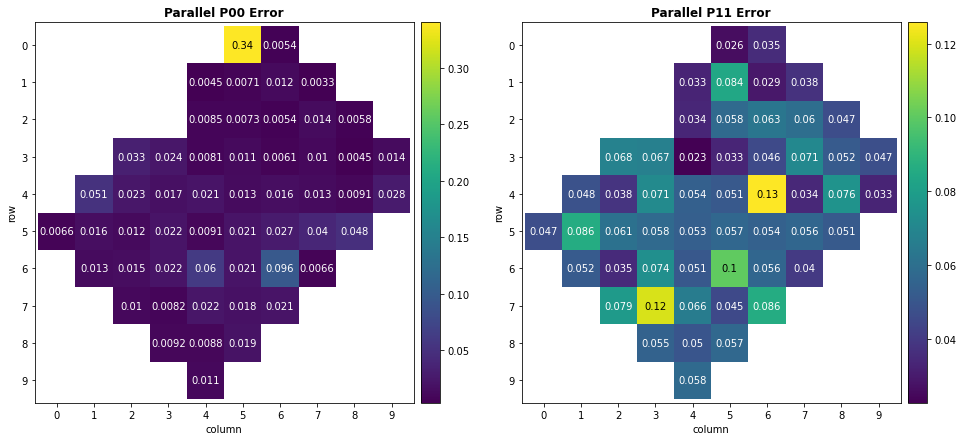

In [6]:
processor_id = "" #@param {type:"string"}
metrics = "parallel_p00_error, parallel_p11_error" #@param {type:"string"}
metrics = [m.strip() for m in metrics.split(sep=",")]

_, axes = plt.subplots(
    nrows=1, ncols=len(metrics), figsize=(min(16, 8 * len(metrics)), 7)
)

calibration = cg.get_engine_calibration(processor_id=processor_id)
for i, metric in enumerate(metrics):
    calibration.heatmap(metric).plot(ax=axes[i] if len(metrics) > 1 else axes);

Using this report as a guide, select a set of qubits.

In [7]:
qubit_indices = [
    (2, 5), (2, 6), (2, 7), (2, 8)  # <-- Select qubit indices here.
]
qubits = [cirq.GridQubit(*idx) for idx in qubit_indices]

## Run a Loschmidt echo benchmark

Execute the following cells to run a Loschmidt echo on the selected qubits. This is done to (i) verify the qubits are comparable to the latest calibration and (ii) establish a baseline for comparing to Floquet and XEB calibration.

Note: See the [Loschmidt echo tutorial](https://quantumai.google/cirq/tutorials/google/echoes) for background about this benchmark.

In [8]:
#@title Helper functions
from typing import Optional, Sequence


def create_xeb_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.FSimGate(np.pi / 4, 0.0),
    seed: Optional[int] = None,
) -> cirq.Circuit:
    return rqcg.random_rotations_between_grid_interaction_layers_circuit(
        qubits, 
        depth=cycles,
        two_qubit_op_factory=lambda a, b, _: twoq_gate.on(a, b),
        pattern=cirq.experiments.GRID_STAGGERED_PATTERN,
        single_qubit_gates=[cirq.PhasedXPowGate(phase_exponent=p, exponent=0.5)
                            for p in np.arange(-1.0, 1.0, 0.25)],
        seed=seed
    )



def create_loschmidt_echo_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.FSimGate(np.pi / 4, 0.0),
    seed: Optional[int] = None,
) -> cirq.Circuit:
    forward = create_xeb_circuit(qubits, cycles, twoq_gate, seed)
    return forward + cirq.inverse(forward) + cirq.measure(*qubits, key="z")



def to_ground_state_prob(result: cirq.Result) -> float:
    return np.mean(np.sum(result.measurements["z"], axis=1) == 0)

In [9]:
"""Run the Loschmidt echo experiment."""
cycle_values = range(0, 80 + 1, 4)
nreps = 20_000
trials = 10
engine = cg.get_engine()

loschmidt_echo_batch = [
    create_loschmidt_echo_circuit(qubits, cycles=c, seed=trial)
    for trial in range(trials) for c in cycle_values
]

results = engine.run_batch(
    programs=loschmidt_echo_batch,
    processor_ids=[processor_id],
    repetitions=nreps,
    gate_set=cg.SQRT_ISWAP_GATESET,
    params_list=[{}] * len(loschmidt_echo_batch),
)

probs = [to_ground_state_prob(res) for res in results]

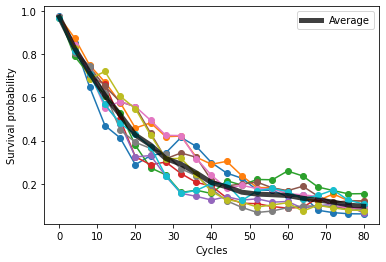

In [10]:
probs = np.array(probs).reshape(trials, len(cycle_values))
for p in probs:
      plt.plot(cycle_values, p, "-o")

avg_probs_uncalibrated = np.average(probs, axis=0)
plt.plot(cycle_values, avg_probs_uncalibrated, lw=5, alpha=0.75, color="black", label="Average")

plt.xlabel("Cycles")
plt.ylabel("Survival probability")
plt.legend();

**Are these results significantly worse than the last calibration?** 

* If yes, select a different set of qubits and re-run the Loschmidt echo benchmark.

* If no, proceed to the next section.

TODO: Explain how to answer this.

## Calibrate qubit pairs

In the next cell, define the quantum circuit for your experiment.

In [11]:
"""Define the quantum circuit for your experiment here."""
circuit = create_xeb_circuit(qubits, 10)

The structure of the circuit instructs the calibration API on which qubit pairs to calibrate. 

After defining options unique to each method, the interface for running Floquet and XEB calibration is identical.

### Floquet calibration setup

Note: See the [Floquet calibration tutorial](https://quantumai.google/cirq/tutorials/google/floquet) for background about this method.

Specify the parameters of the `cirq.FSimGate` to characterize with Floquet calibration below.

In [12]:
floquet_options = cg.FloquetPhasedFSimCalibrationOptions(
    characterize_theta=False,
    characterize_zeta=True,
    characterize_chi=False,
    characterize_gamma=True,
    characterize_phi=False
)

### XEB calibration setup

Note: See the [XEB theory tutorial](https://quantumai.google/cirq/qcvv/xeb_theory) for background about this method.

Specify the cycle depths and other options for XEB calibration below. Note that all `cirq.FSimGate` parameters are characterized by default.

In [13]:
xeb_options = cg.LocalXEBPhasedFSimCalibrationOptions(
    cycle_depths=(5, 25, 50, 100),
    n_processes=1,
)

### Run each calibration

Execute the following cell to run each calibration with the above options.

In [14]:
all_options = [floquet_options, xeb_options]
sampler = cg.get_engine_sampler(processor_id=processor_id, gate_set_name="sqrt_iswap")

all_characterizations = []
for options in all_options:
    # Get characterization requests.
    _, characterization_requests = cg.prepare_characterization_for_moments(
        circuit,
        options=options
    )
    
    # Characterize the requests on the engine.
    characterizations = cg.run_calibrations(characterization_requests, sampler)
    all_characterizations.append(characterizations)

100%|██████████| 45/45 [02:40<00:00,  3.57s/it]


## Re-run the Loschmidt echo with corrections

Execute the following cell to apply corrections to each circuit in the Loschmidt echo benchmark and re-run the experiment. The corrections are based on the characterizations from the previous cell.

In [15]:
"""Run the Loschmidt echo again, this time with Floquet & XEB calibration."""
all_calibrated_probs = []
for (options, characterizations) in zip(all_options, all_characterizations):
    # Apply corrections to the Loschmidt echo batch from the characterizations.
    characterized_batch = [
        cg.prepare_characterization_for_moments(circuit, options)[0] 
        for circuit in loschmidt_echo_batch
    ]
    calibrated_batch = [
        cg.make_zeta_chi_gamma_compensation_for_moments(circ, characterizations).circuit
        for circ in characterized_batch
    ]

    # Run the corrected Loschmidt echo batch.
    calibrated_results = engine.run_batch(
        programs=calibrated_batch,
        processor_ids=[processor_id],
        repetitions=nreps,
        gate_set=cg.SQRT_ISWAP_GATESET,
        params_list=[{}] * len(calibrated_batch),
    )

    # Compute survival probabilities.
    calibrated_probs = [to_ground_state_prob(res) for res in calibrated_results]
    all_calibrated_probs.append(
        np.array(calibrated_probs).reshape(trials, len(cycle_values))
    )

The next cell plots the results.

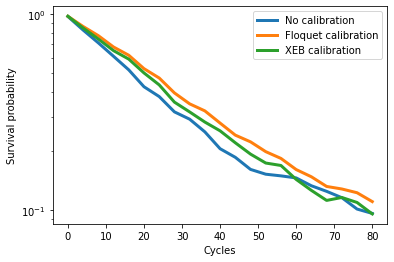

In [16]:
to_plot = [avg_probs_uncalibrated] + [np.average(calibrated_probs, axis=0) for calibrated_probs in all_calibrated_probs]
labels = ["No calibration", "Floquet calibration", "XEB calibration"]

for probs, label in zip(to_plot, labels):
    plt.semilogy(cycle_values, probs, lw=3, label=label)

plt.xlabel("Cycles")
plt.ylabel("Survival probability")
plt.legend();

## Apply corrections to your circuit

Now, use the calibration which gives the best results on the Loschmidt echo benchmark.

In [5]:
calibration_to_use = "floquet " #@param {type:"string"}
index = {"floquet": 0, "xeb": 1}.get(calibration_to_use.strip().lower())

The following cell shows how to apply corrections to your circuit from either calibration.

In [ ]:
characterized_circuit, _ = cg.prepare_characterization_for_moments(
    circuit, options=all_options[index],
)
calibrated_circuit = cg.make_zeta_chi_gamma_compensation_for_moments(
    characterized_circuit,
    all_characterizations[index],
)
print("Calibrated circuit:\n")
print(calibrated_circuit.circuit)

You can now run this calibrated circuit on the Quantum Computing Service.